In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler

# Notebook 1: Data Preprocessing

## Data Loading

In [4]:
df = pd.read_csv("compas-scores.csv")
print(df.shape)

(11757, 47)


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11757 entries, 0 to 11756
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       11757 non-null  int64  
 1   name                     11757 non-null  object 
 2   first                    11757 non-null  object 
 3   last                     11757 non-null  object 
 4   compas_screening_date    11757 non-null  object 
 5   sex                      11757 non-null  object 
 6   dob                      11757 non-null  object 
 7   age                      11757 non-null  int64  
 8   age_cat                  11757 non-null  object 
 9   race                     11757 non-null  object 
 10  juv_fel_count            11757 non-null  int64  
 11  decile_score             11757 non-null  int64  
 12  juv_misd_count           11757 non-null  int64  
 13  juv_other_count          11757 non-null  int64  
 14  priors_count          

In [6]:
print(df.isnull().sum())


id                             0
name                           0
first                          0
last                           0
compas_screening_date          0
sex                            0
dob                            0
age                            0
age_cat                        0
race                           0
juv_fel_count                  0
decile_score                   0
juv_misd_count                 0
juv_other_count                0
priors_count                   0
days_b_screening_arrest     1180
c_jail_in                   1180
c_jail_out                  1180
c_case_number                742
c_offense_date              2600
c_arrest_date               9899
c_days_from_compas           742
c_charge_degree                0
c_charge_desc                749
is_recid                       0
num_r_cases                11757
r_case_number               8054
r_charge_degree                0
r_days_from_arrest          9297
r_offense_date              8054
r_charge_d

In [7]:
# Convert to datetime objects
df['screening_date'] = pd.to_datetime(df['screening_date'], errors='coerce')
df['r_offense_date'] = pd.to_datetime(df['r_offense_date'], errors='coerce')

In [8]:
# Compute days between initial screening and first re-offense (if any)
df['days_to_recid'] = (df['r_offense_date'] - df['screening_date']).dt.days

In [9]:
# Assign 1 if recidivated within 2 years (730 days), else 0
df['two_year_recid'] = ((df['days_to_recid'] >= 0) & (df['days_to_recid'] <= 730)).astype(int)

In [10]:
df_clean = df[df['screening_date'].notnull()]
df_clean = df_clean[df_clean['two_year_recid'].notnull()]

In [11]:
print(df_clean.columns)

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'num_r_cases',
       'r_case_number', 'r_charge_degree', 'r_days_from_arrest',
       'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out',
       'is_violent_recid', 'num_vr_cases', 'vr_case_number',
       'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'type_of_assessment', 'decile_score.1',
       'score_text', 'screening_date', 'days_to_recid', 'two_year_recid'],
      dtype='object')


In [12]:
df_clean['c_charge_degree'].value_counts()

,count
c_charge_degree,
F,7232
M,3771
O,754


## EDA

In [13]:
features = [
    'age', 'sex', 'race', 'priors_count',
    'juv_fel_count', 'juv_misd_count', 'juv_other_count',
    'c_charge_degree'
]

target = 'two_year_recid'

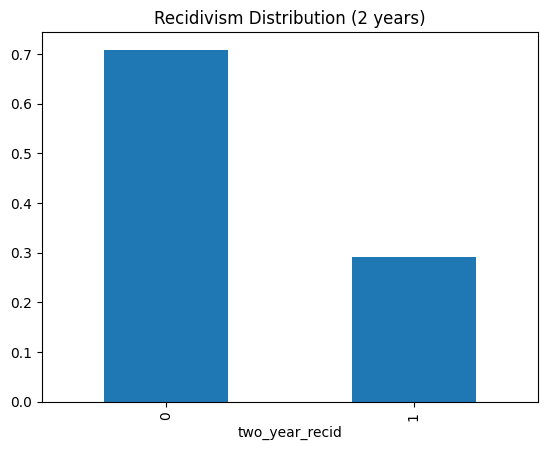

In [14]:
import matplotlib.pyplot as plt

df_clean[target].value_counts(normalize=True).plot(kind='bar')
plt.title("Recidivism Distribution (2 years)")
plt.show()

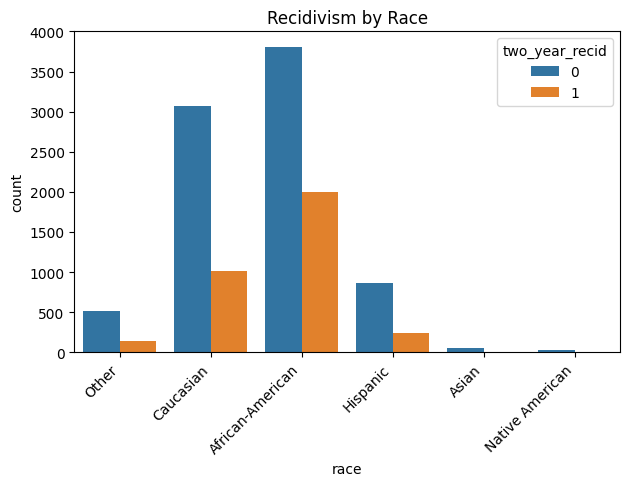

In [15]:
import seaborn as sns
sns.countplot(x='race', hue=target, data=df_clean)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.title("Recidivism by Race")
plt.show()

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'decile_score'}>],
       [<Axes: title={'center': 'priors_count'}>,
        <Axes: title={'center': 'juv_fel_count'}>],
       [<Axes: title={'center': 'juv_misd_count'}>,
        <Axes: title={'center': 'juv_other_count'}>]], dtype=object)

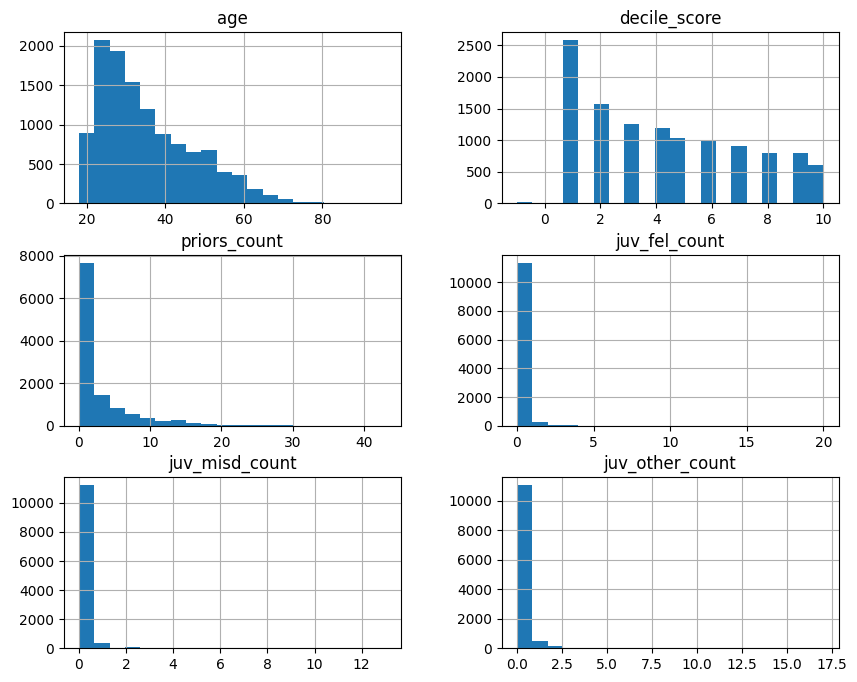

In [16]:
num_cols = ['age', 'decile_score', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count']
df[num_cols].hist(bins=20, figsize=(10, 8))

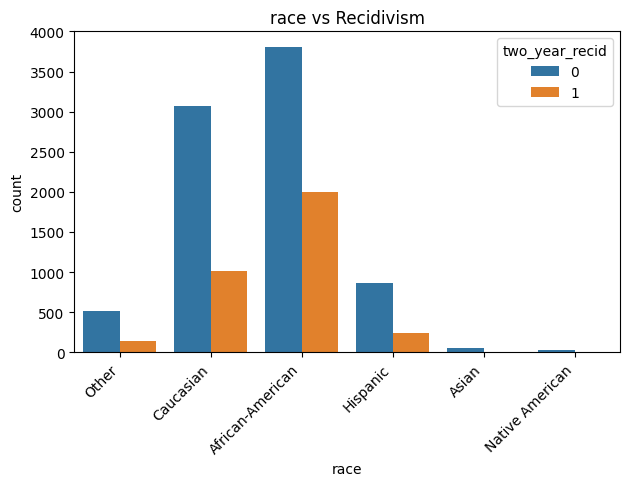

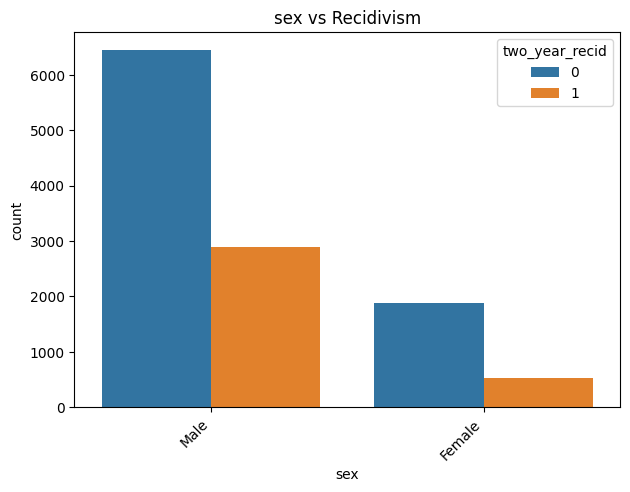

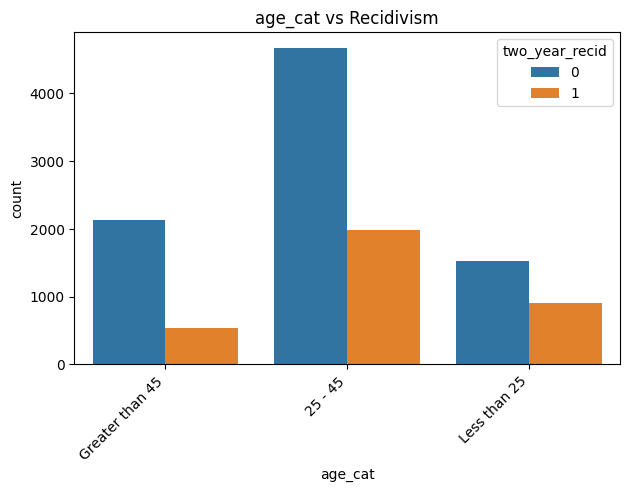

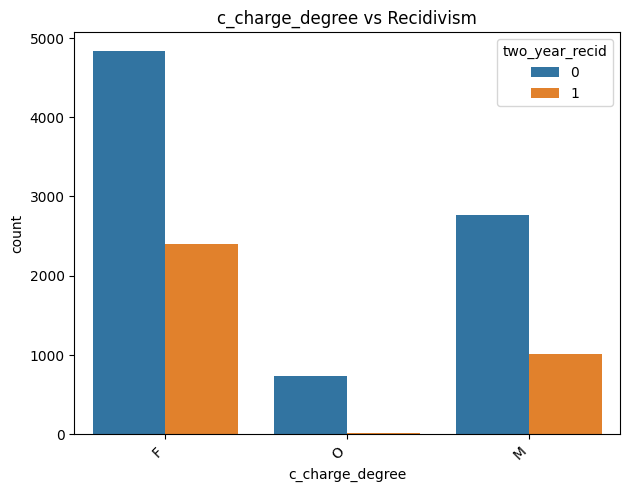

In [17]:
cat_cols = ['race', 'sex', 'age_cat', 'c_charge_degree']
for col in cat_cols:
    sns.countplot(x=col, hue='two_year_recid', data=df)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.title(f'{col} vs Recidivism')
    plt.show()

<Axes: >

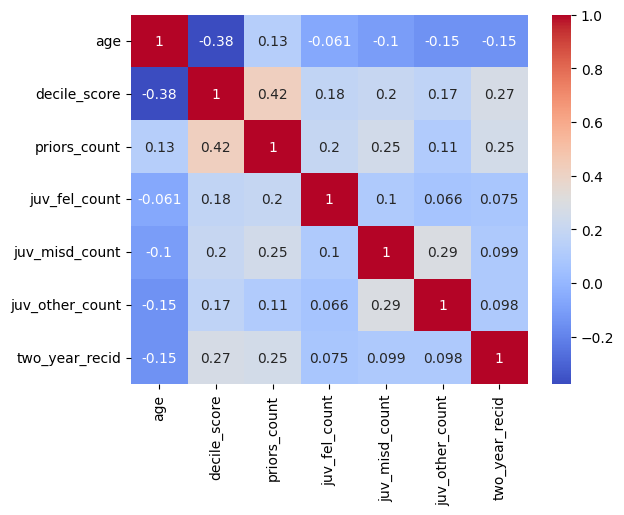

In [18]:
corr = df[num_cols + ['two_year_recid']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")

# Notebook 2: Modelling and Training

## Model Training (with 'race' feature)

In [51]:
# Define categorical and numerical columns
categorical = ['sex', 'race', 'c_charge_degree']
numerical = ['age', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count']

# Preprocess: one-hot encode categoricals
numeric_transformer = Pipeline([
    ('log', FunctionTransformer(np.log1p, validate=False)),
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', OneHotEncoder(drop='first'), categorical)
    ]
)

In [52]:
X = df_clean.drop(columns=[target])
y = df_clean[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define models and corresponding hyperparameter grids
models_with_params = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            "classifier__C": [0.01, 0.1, 1, 10],
            "classifier__penalty": ["l2"],
            "classifier__solver": ["lbfgs"],
        }
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "classifier__max_depth": [None, 5, 10, 20],
            "classifier__min_samples_split": [2, 5, 10],
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "classifier__n_estimators": [100, 200],
            "classifier__max_depth": [None, 5, 10],
            "classifier__min_samples_split": [2, 5],
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "classifier__n_estimators": [100, 200],
            "classifier__learning_rate": [0.05, 0.1],
            "classifier__max_depth": [3, 5],
        }
    },
}

# Create storage for best models and results
best_models = {}
best_scores = {}

for name, mp in models_with_params.items():
    print(f"\nTraining and tuning {name}...")

    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', mp['model'])
    ])

    # Set up GridSearchCV
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=mp['params'],
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )

    # Train using cross-validation
    grid.fit(X_train, y_train)

    best_models[name] = grid.best_estimator_
    best_scores[name] = grid.best_score_

    print(f"Best ROC-AUC for {name}: {grid.best_score_:.4f}")
    print(f"Best hyperparameters: {grid.best_params_}")

print("\n\nTuning complete. Best models:")
for name, score in best_scores.items():
    print(f"{name}: ROC-AUC = {score:.4f}")



Training and tuning Logistic Regression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best ROC-AUC for Logistic Regression: 0.7313
Best hyperparameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}

Training and tuning Decision Tree...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best ROC-AUC for Decision Tree: 0.7184
Best hyperparameters: {'classifier__max_depth': 5, 'classifier__min_samples_split': 10}

Training and tuning Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best ROC-AUC for Random Forest: 0.7280
Best hyperparameters: {'classifier__max_depth': 5, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}

Training and tuning Gradient Boosting...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best ROC-AUC for Gradient Boosting: 0.7300
Best hyperparameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}

In [54]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

print("\n=== Final Model Evaluation on Test Set ===")

for name, model in best_models.items():
    print(f"\n{name} (Best CV ROC-AUC: {best_scores[name]:.4f})")

    # Predict labels and probabilities
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Compute evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    # Print results
    print(f"Test Accuracy: {acc:.2f}")
    print(f"Test ROC-AUC: {roc_auc:.2f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


=== Final Model Evaluation on Test Set ===

Logistic Regression (Best CV ROC-AUC: 0.7313)
Test Accuracy: 0.73
Test ROC-AUC: 0.72
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.92      0.83      1667
           1       0.57      0.25      0.35       685

    accuracy                           0.73      2352
   macro avg       0.66      0.59      0.59      2352
weighted avg       0.70      0.73      0.69      2352


Decision Tree (Best CV ROC-AUC: 0.7184)
Test Accuracy: 0.72
Test ROC-AUC: 0.70
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.93      0.82      1667
           1       0.54      0.19      0.28       685

    accuracy                           0.72      2352
   macro avg       0.64      0.56      0.55      2352
weighted avg       0.68      0.72      0.67      2352


Random Forest (Best CV ROC-AUC: 0.7280)
Test Accuracy: 0.72
Test ROC-AUC: 0.72
Classifica


=== Confusion Matrices for Best Models ===

Confusion Matrix for Logistic Regression:


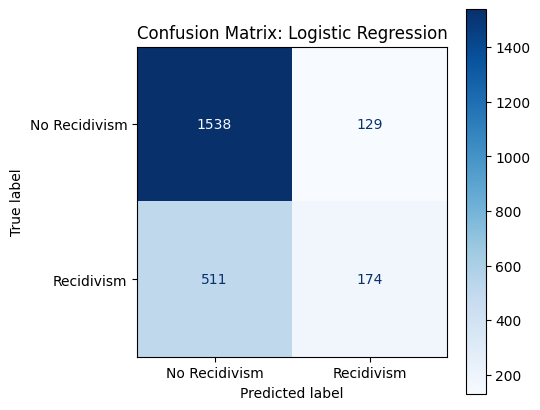


Confusion Matrix for Decision Tree:


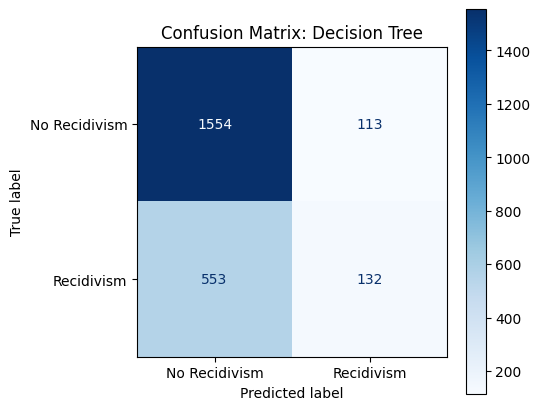


Confusion Matrix for Random Forest:


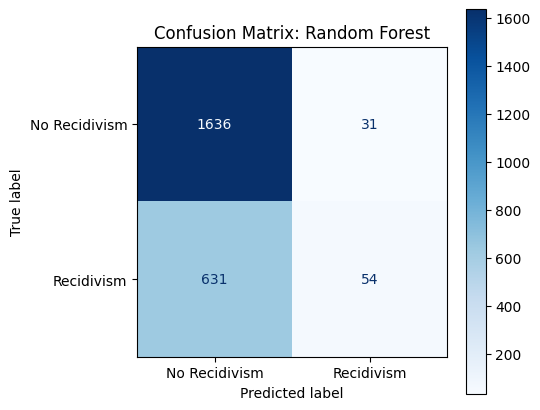


Confusion Matrix for Gradient Boosting:


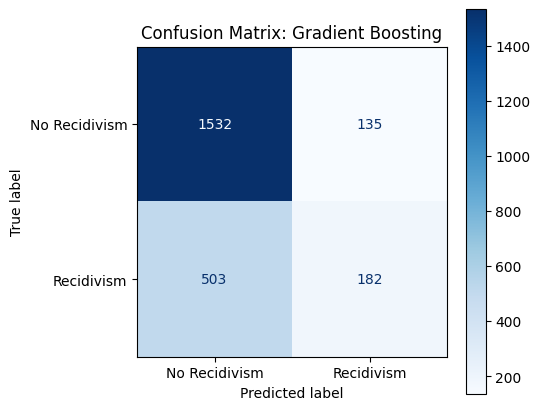

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("\n=== Confusion Matrices for Best Models ===")

for name, model in best_models.items():  # Iterate over tuned best models
    print(f"\nConfusion Matrix for {name}:")

    fig, ax = plt.subplots(figsize=(5, 5))  # Optional: specify figure size
    ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=["No Recidivism", "Recidivism"],  # Optional: human-readable labels
        cmap="Blues",
        ax=ax
    )

    ax.set_title(f"Confusion Matrix: {name}")
    plt.show()


# Notebook 3: Evaluation and Fairness

## Recidivism: Analysis based on Race

In [56]:
print("\n=== Global Model Evaluation ===")

global_results = []

for name, model in best_models.items():
    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f"\n{name}:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")
    print("  Classification Report:")
    print(classification_report(y_test, y_pred))

    # Append to results
    global_results.append({
        'Model': name,
        'Accuracy': acc,
        'ROC-AUC': roc_auc
    })

# Summary DataFrame
global_results_df = pd.DataFrame(global_results)
display(global_results_df)


=== Global Model Evaluation ===

Logistic Regression:
  Accuracy: 0.7279
  ROC-AUC: 0.7170
  Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.92      0.83      1667
           1       0.57      0.25      0.35       685

    accuracy                           0.73      2352
   macro avg       0.66      0.59      0.59      2352
weighted avg       0.70      0.73      0.69      2352


Decision Tree:
  Accuracy: 0.7168
  ROC-AUC: 0.7032
  Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.93      0.82      1667
           1       0.54      0.19      0.28       685

    accuracy                           0.72      2352
   macro avg       0.64      0.56      0.55      2352
weighted avg       0.68      0.72      0.67      2352


Random Forest:
  Accuracy: 0.7185
  ROC-AUC: 0.7183
  Classification Report:
              precision    recall  f1-score   support

           0      

,Model,Accuracy,ROC-AUC
0,Logistic Regression,0.727891,0.717013
1,Decision Tree,0.716837,0.703241
2,Random Forest,0.718537,0.718337
3,Gradient Boosting,0.728741,0.723725


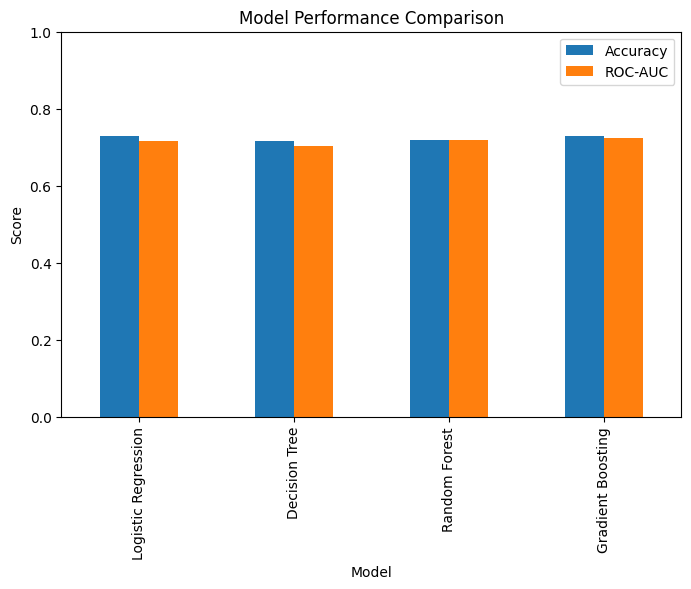

In [57]:
# Bar chart of model performance
global_results_df.set_index('Model')[['Accuracy', 'ROC-AUC']].plot(kind='bar', figsize=(8, 5))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()

In [58]:
def subgroup_stats(model, X, y, sensitive_series):
    results = []
    for group in sensitive_series.unique():
        group_idx = (sensitive_series == group)

        y_true_group = y[group_idx]
        y_pred_group = model.predict(X[group_idx])

        # Collect key metrics
        results.append({
            'Group': group,
            'Size': group_idx.sum(),
            'Accuracy': accuracy_score(y_true_group, y_pred_group),
            'FPR': np.mean((y_true_group == 0) & (y_pred_group == 1)),  # FP / (FP+TN)
            'FNR': np.mean((y_true_group == 1) & (y_pred_group == 0)),  # FN / (FN+TP)
            'TPR': np.mean((y_true_group == 1) & (y_pred_group == 1)),  # TP / (TP+FN)
            'Selection Rate': np.mean(y_pred_group == 1)  # Predicted Positive Rate
        })
    return pd.DataFrame(results)

print("\n=== Subgroup Performance by Race ===")
for name, model in best_models.items():
    print(f"\n{name}:")
    subgroup_df = subgroup_stats(model, X_test, y_test, X_test['race'])
    display(subgroup_df)


=== Subgroup Performance by Race ===

Logistic Regression:


,Group,Size,Accuracy,FPR,FNR,TPR,Selection Rate
0,African-American,1115,0.693274,0.090583,0.216143,0.120179,0.210762
1,Other,128,0.718750,0.031250,0.250000,0.015625,0.046875
2,Caucasian,869,0.767549,0.020713,0.211738,0.037975,0.058688
3,Hispanic,217,0.737327,0.027650,0.235023,0.018433,0.046083
4,Native American,9,0.888889,0.000000,0.111111,0.111111,0.111111
5,Asian,14,0.857143,0.000000,0.142857,0.000000,0.000000



Decision Tree:


,Group,Size,Accuracy,FPR,FNR,TPR,Selection Rate
0,African-American,1115,0.681614,0.068161,0.250224,0.086099,0.154260
1,Other,128,0.734375,0.031250,0.234375,0.031250,0.062500
2,Caucasian,869,0.754891,0.027618,0.217491,0.032221,0.059839
3,Hispanic,217,0.723502,0.036866,0.239631,0.013825,0.050691
4,Native American,9,0.888889,0.000000,0.111111,0.111111,0.111111
5,Asian,14,0.785714,0.071429,0.142857,0.000000,0.071429



Random Forest:


,Group,Size,Accuracy,FPR,FNR,TPR,Selection Rate
0,African-American,1115,0.684305,0.021525,0.294170,0.042152,0.063677
1,Other,128,0.734375,0.007812,0.257812,0.007812,0.015625
2,Caucasian,869,0.750288,0.005754,0.243959,0.005754,0.011507
3,Hispanic,217,0.746544,0.004608,0.248848,0.004608,0.009217
4,Native American,9,0.777778,0.000000,0.222222,0.000000,0.000000
5,Asian,14,0.857143,0.000000,0.142857,0.000000,0.000000



Gradient Boosting:


,Group,Size,Accuracy,FPR,FNR,TPR,Selection Rate
0,African-American,1115,0.694170,0.090583,0.215247,0.121076,0.211659
1,Other,128,0.734375,0.039062,0.226562,0.039062,0.078125
2,Caucasian,869,0.764097,0.027618,0.208285,0.041427,0.069045
3,Hispanic,217,0.751152,0.018433,0.230415,0.023041,0.041475
4,Native American,9,0.888889,0.000000,0.111111,0.111111,0.111111
5,Asian,14,0.785714,0.071429,0.142857,0.000000,0.071429


In [59]:
def fairness_metrics(model, X, y, sensitive_series):
    # Overall positive prediction rate for reference
    y_pred = model.predict(X)
    overall_positive_rate = np.mean(y_pred)

    metrics = []
    for group in sensitive_series.unique():
        group_idx = (sensitive_series == group)
        y_true = y[group_idx]
        y_pred_group = y_pred[group_idx]

        pos_rate = np.mean(y_pred_group)  # Demographic parity
        tpr = np.mean(y_pred_group[y_true == 1]) if (y_true == 1).any() else 0
        fpr = np.mean(y_pred_group[y_true == 0]) if (y_true == 0).any() else 0

        metrics.append({
            'Group': group,
            'Positive Rate': pos_rate,
            'TPR': tpr,
            'FPR': fpr,
            'DP Difference': pos_rate - overall_positive_rate,
        })

    return pd.DataFrame(metrics)

print("\n=== Manual Fairness Metrics ===")
for name, model in best_models.items():
    print(f"\n{name}:")
    fairness_df = fairness_metrics(model, X_test, y_test, X_test['race'])
    display(fairness_df)



=== Manual Fairness Metrics ===

Logistic Regression:


,Group,Positive Rate,TPR,FPR,DP Difference
0,African-American,0.210762,0.357333,0.136486,0.081936
1,Other,0.046875,0.058824,0.042553,-0.081952
2,Caucasian,0.058688,0.152074,0.027607,-0.070138
3,Hispanic,0.046083,0.072727,0.037037,-0.082744
4,Native American,0.111111,0.500000,0.000000,-0.017715
5,Asian,0.000000,0.000000,0.000000,-0.128827



Decision Tree:


,Group,Positive Rate,TPR,FPR,DP Difference
0,African-American,0.154260,0.256000,0.102703,0.050093
1,Other,0.062500,0.117647,0.042553,-0.041667
2,Caucasian,0.059839,0.129032,0.036810,-0.044328
3,Hispanic,0.050691,0.054545,0.049383,-0.053475
4,Native American,0.111111,0.500000,0.000000,0.006944
5,Asian,0.071429,0.000000,0.083333,-0.032738



Random Forest:


,Group,Positive Rate,TPR,FPR,DP Difference
0,African-American,0.063677,0.125333,0.032432,0.027538
1,Other,0.015625,0.029412,0.010638,-0.020514
2,Caucasian,0.011507,0.023041,0.007669,-0.024632
3,Hispanic,0.009217,0.018182,0.006173,-0.026923
4,Native American,0.000000,0.000000,0.000000,-0.036139
5,Asian,0.000000,0.000000,0.000000,-0.036139



Gradient Boosting:


,Group,Positive Rate,TPR,FPR,DP Difference
0,African-American,0.211659,0.360000,0.136486,0.076880
1,Other,0.078125,0.147059,0.053191,-0.056654
2,Caucasian,0.069045,0.165899,0.036810,-0.065734
3,Hispanic,0.041475,0.090909,0.024691,-0.093304
4,Native American,0.111111,0.500000,0.000000,-0.023668
5,Asian,0.071429,0.000000,0.083333,-0.063350


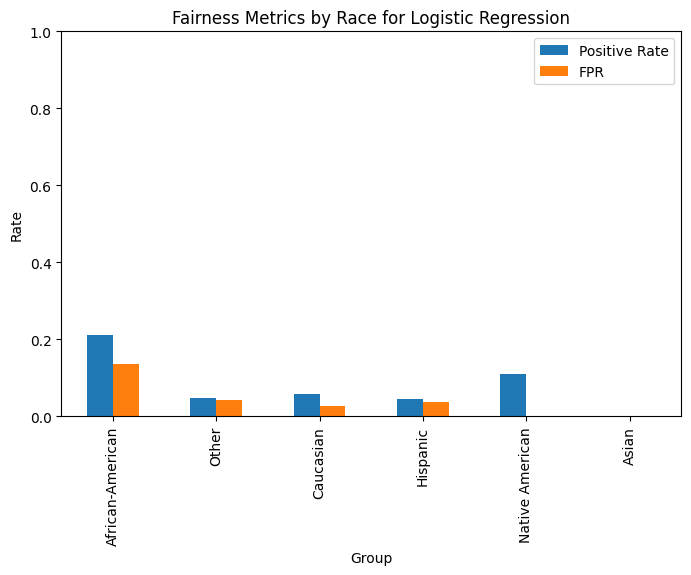

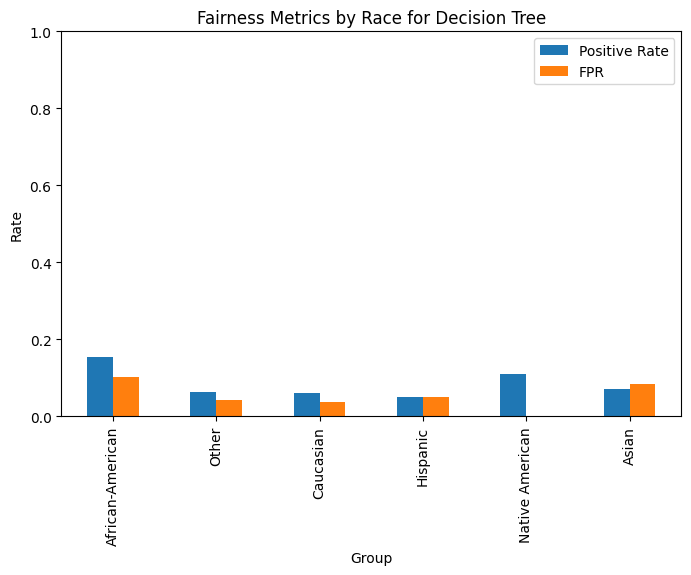

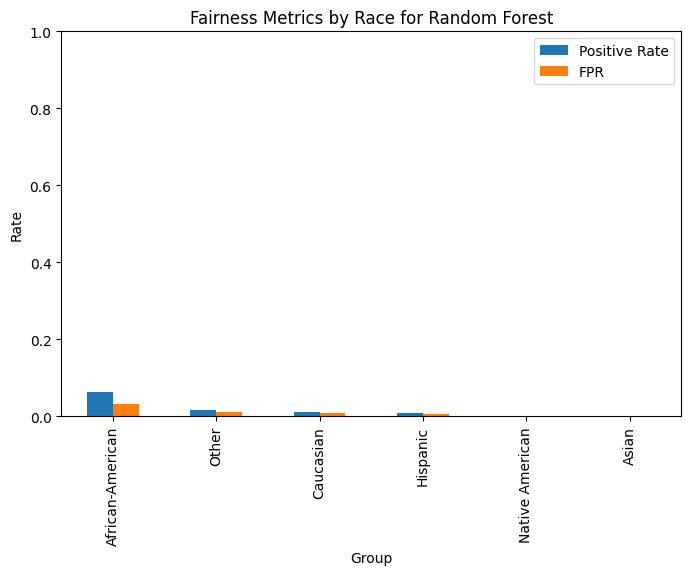

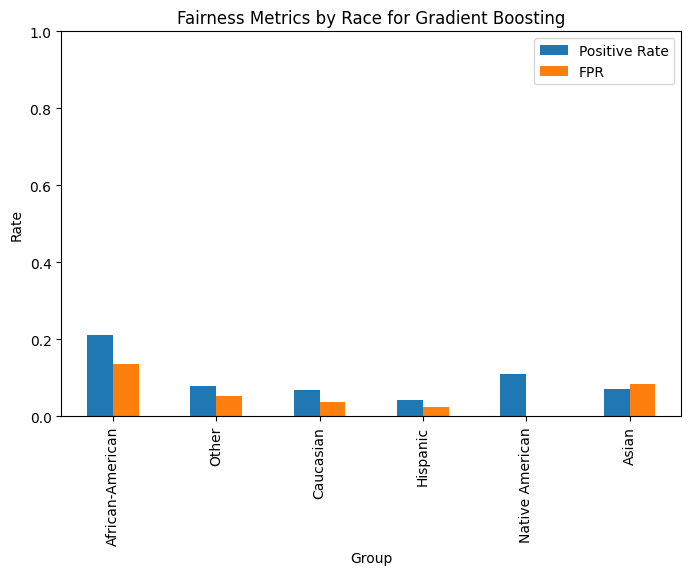

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

for name, model in best_models.items():
    fairness_df = fairness_metrics(model, X_test, y_test, X_test['race'])

    fairness_df.set_index('Group')[['Positive Rate', 'FPR']].plot(kind='bar', figsize=(8, 5))
    plt.title(f"Fairness Metrics by Race for {name}")
    plt.ylabel("Rate")
    plt.ylim(0, 1)
    plt.show()

In [29]:
# def compute_group_metrics(df, group_col='race', positive_label=1):
#     groups = df[group_col].unique()
#     metrics = []

#     for group in groups:
#         subset = df[df[group_col] == group]
#         tn, fp, fn, tp = confusion_matrix(subset['actual'], subset['predicted']).ravel()

#         # Compute rates
#         fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
#         fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
#         tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
#         tnr = tn / (tn + fp) if (tn + fp) > 0 else 0

#         metrics.append({
#             'group': group,
#             'FPR': fpr,
#             'FNR': fnr,
#             'TPR': tpr,
#             'TNR': tnr,
#             'count': len(subset)
#         })

#     return pd.DataFrame(metrics)

# Notebook 4: Interpretability and Conclusions

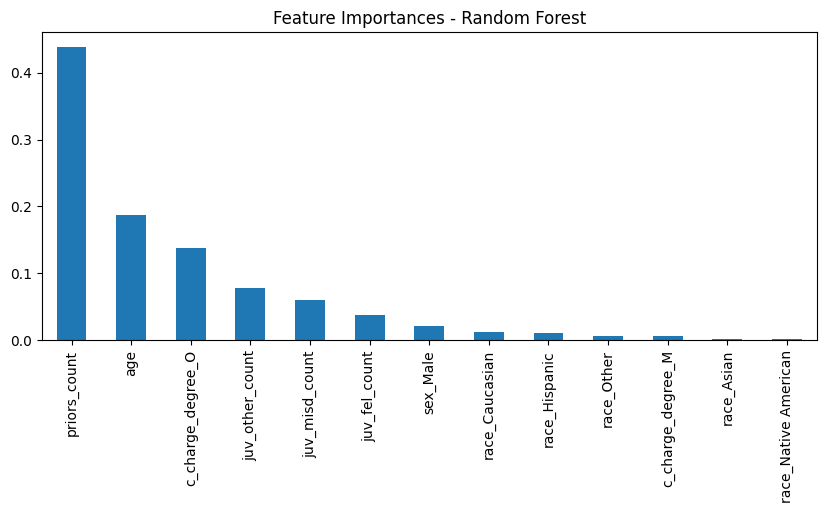

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# Get the fitted preprocessor from the best Random Forest model
preprocessor_fitted = best_models["Random Forest"].named_steps['preprocessor']

# Manually construct feature names
numerical_feature_names_out = numerical
ohe_transformer_fitted = preprocessor_fitted.named_transformers_['cat']
categorical_feature_names_out = ohe_transformer_fitted.get_feature_names_out(categorical)

# Combine all feature names
feature_names = list(numerical_feature_names_out) + list(categorical_feature_names_out)

importances = best_models["Random Forest"].named_steps['classifier'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
feat_imp.plot(kind='bar', figsize=(10, 4))
plt.title("Feature Importances - Random Forest")
plt.show()

# Removing 'race'

## Model Training (without 'race' feature)

In [36]:
# Define categorical and numerical columns
categorical = ['sex', 'c_charge_degree']
numerical = ['age', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count']

# Preprocess: one-hot encode categoricals
numeric_transformer = Pipeline([
    ('log', FunctionTransformer(np.log1p, validate=False)),
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', OneHotEncoder(drop='first'), categorical)
    ]
)

In [37]:
X = df_clean.drop(columns=[target])
y = df_clean[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Initialize raw models
raw_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Create a new dictionary to store the trained pipelines
trained_pipelines = {}

for name, clf_model in raw_models.items():
    print(f"Training {name}...")

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', clf_model)
    ])

    pipeline.fit(X_train, y_train)
    trained_pipelines[name] = pipeline # Store the trained pipeline

    print(f"{name} trained successfully.")

Training Logistic Regression...
Logistic Regression trained successfully.
Training Random Forest...
Random Forest trained successfully.


In [39]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

for name, pipeline in trained_pipelines.items(): # Iterate over the trained pipelines
    y_pred = pipeline.predict(X_test) # Predict using the pipeline
    y_proba = pipeline.predict_proba(X_test)[:, 1] # Get probabilities using the pipeline
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.2f}")
    print(classification_report(y_test, y_pred))


Logistic Regression Results:
Accuracy: 0.73
ROC-AUC: 0.72
              precision    recall  f1-score   support

           0       0.75      0.92      0.83      1667
           1       0.57      0.26      0.35       685

    accuracy                           0.73      2352
   macro avg       0.66      0.59      0.59      2352
weighted avg       0.70      0.73      0.69      2352


Random Forest Results:
Accuracy: 0.70
ROC-AUC: 0.66
              precision    recall  f1-score   support

           0       0.75      0.87      0.80      1667
           1       0.46      0.28      0.35       685

    accuracy                           0.70      2352
   macro avg       0.61      0.57      0.58      2352
weighted avg       0.66      0.70      0.67      2352



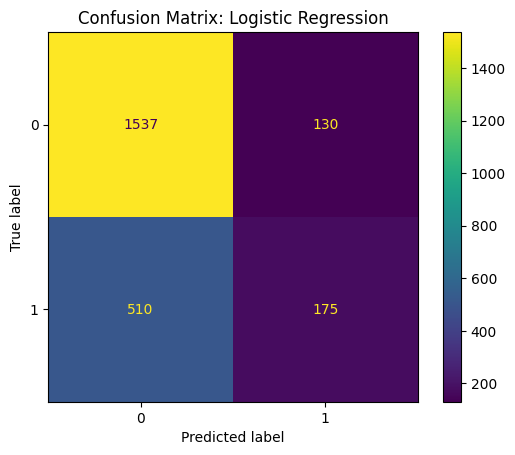

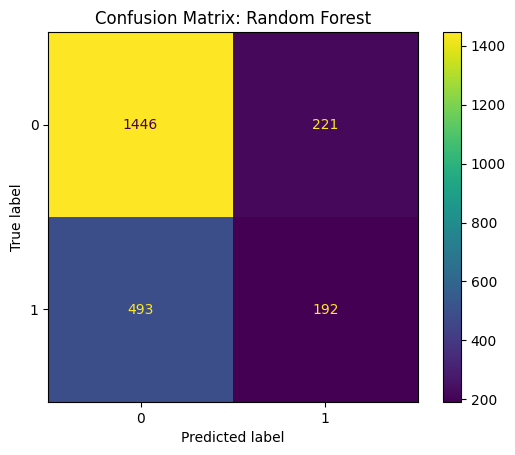

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt # Ensure plt is imported for show()

for name, pipeline in trained_pipelines.items(): # Iterate over the trained pipelines
    ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

## Recidivism: Analysis based on Race (without 'race' feature)

In [41]:
import pandas as pd
from sklearn.metrics import confusion_matrix

results = []

for name, pipeline in trained_pipelines.items():
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    df_eval = pd.DataFrame({
        'race': X_test['race'],
        'actual': y_test,
        'predicted': y_pred,
        'probability': y_proba
    })

    results.append((name, df_eval))

In [42]:
def compute_group_metrics(df, group_col='race', positive_label=1):
    groups = df[group_col].unique()
    metrics = []

    for group in groups:
        subset = df[df[group_col] == group]
        tn, fp, fn, tp = confusion_matrix(subset['actual'], subset['predicted']).ravel()

        # Compute rates
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        tnr = tn / (tn + fp) if (tn + fp) > 0 else 0

        metrics.append({
            'group': group,
            'FPR': fpr,
            'FNR': fnr,
            'TPR': tpr,
            'TNR': tnr,
            'count': len(subset)
        })

    return pd.DataFrame(metrics)

In [43]:
# Compute and display fairness metrics
for name, df_eval in results:
    print(f"\nFairness Metrics for {name}:")
    fairness_df = compute_group_metrics(df_eval)
    print(fairness_df)



Fairness Metrics for Logistic Regression:
              group       FPR       FNR       TPR       TNR  count
0  African-American  0.131081  0.653333  0.346667  0.868919   1115
1             Other  0.042553  0.852941  0.147059  0.957447    128
2         Caucasian  0.033742  0.843318  0.156682  0.966258    869
3          Hispanic  0.043210  0.909091  0.090909  0.956790    217
4   Native American  0.000000  0.500000  0.500000  1.000000      9
5             Asian  0.000000  1.000000  0.000000  1.000000     14

Fairness Metrics for Random Forest:
              group       FPR       FNR       TPR       TNR  count
0  African-American  0.162162  0.645333  0.354667  0.837838   1115
1             Other  0.063830  0.882353  0.117647  0.936170    128
2         Caucasian  0.110429  0.811060  0.188940  0.889571    869
3          Hispanic  0.129630  0.745455  0.254545  0.870370    217
4   Native American  0.142857  1.000000  0.000000  0.857143      9
5             Asian  0.083333  1.000000  0.000000

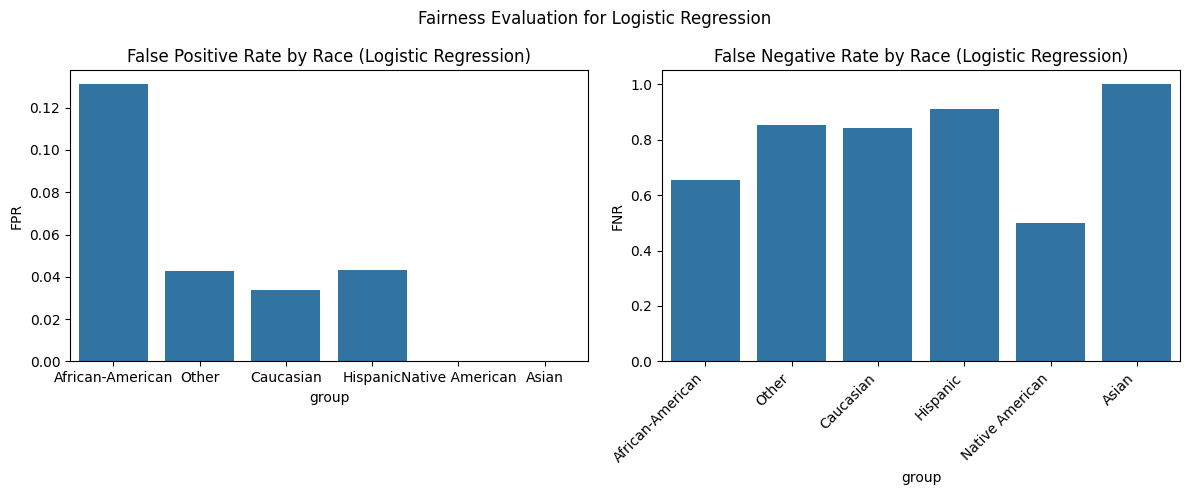

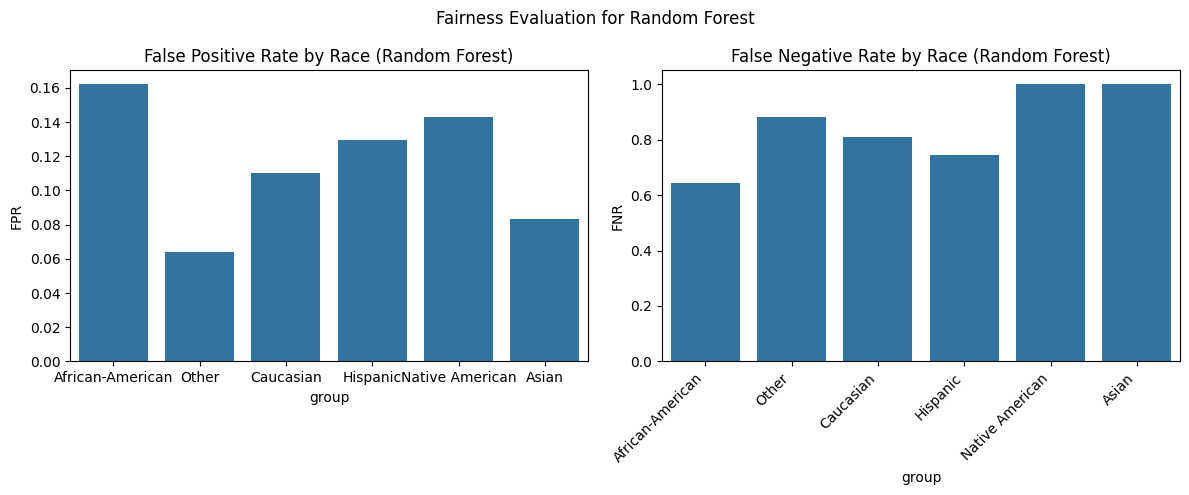

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

for name, df_eval in results:
    fairness_df = compute_group_metrics(df_eval)

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    sns.barplot(data=fairness_df, x='group', y='FPR', ax=ax[0])
    ax[0].set_title(f'False Positive Rate by Race ({name})')

    sns.barplot(data=fairness_df, x='group', y='FNR', ax=ax[1])
    ax[1].set_title(f'False Negative Rate by Race ({name})')

    plt.suptitle(f'Fairness Evaluation for {name}')

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.show()